# Evaluación entre diferentes modelos de regresión

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib
import os


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preparación de datos
# ==============================================================================
from sklearn.neighbors import LocalOutlierFactor

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
#from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [3]:
#Carga del dataset

dp=pd.read_csv('./datasets/01_carDetailsV4_Prue.csv')
dp.shape

(161, 15)

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               161 non-null    float64
 1   Year                161 non-null    float64
 2   Kilometer           161 non-null    float64
 3   Engine              161 non-null    float64
 4   Length              161 non-null    float64
 5   Width               161 non-null    float64
 6   Height              161 non-null    float64
 7   Seating Capacity    161 non-null    float64
 8   Fuel Tank Capacity  161 non-null    float64
 9   Fuel Type           161 non-null    object 
 10  Transmission        161 non-null    object 
 11  Owner               161 non-null    object 
 12  Seller Type         161 non-null    object 
 13  Drivetrain          161 non-null    object 
 14  PriceRange          161 non-null    int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 19.0+ KB

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head(2)

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Manual,First,Individual,FWD
1,Diesel,Manual,First,Individual,RWD


In [8]:
#Lista de variables numéricas

numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

dp[numCols].head(2)

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,9588.0,2019.0,37500.0,1197.0,3995.0,1745.0,1510.0,5.0,37.0,2
1,23400.0,2018.0,69000.0,2393.0,4735.0,1830.0,1795.0,7.0,55.0,2


In [9]:
## Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, dp , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
## Visualización de variables numéricas
#multiple_plot(1, dp , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

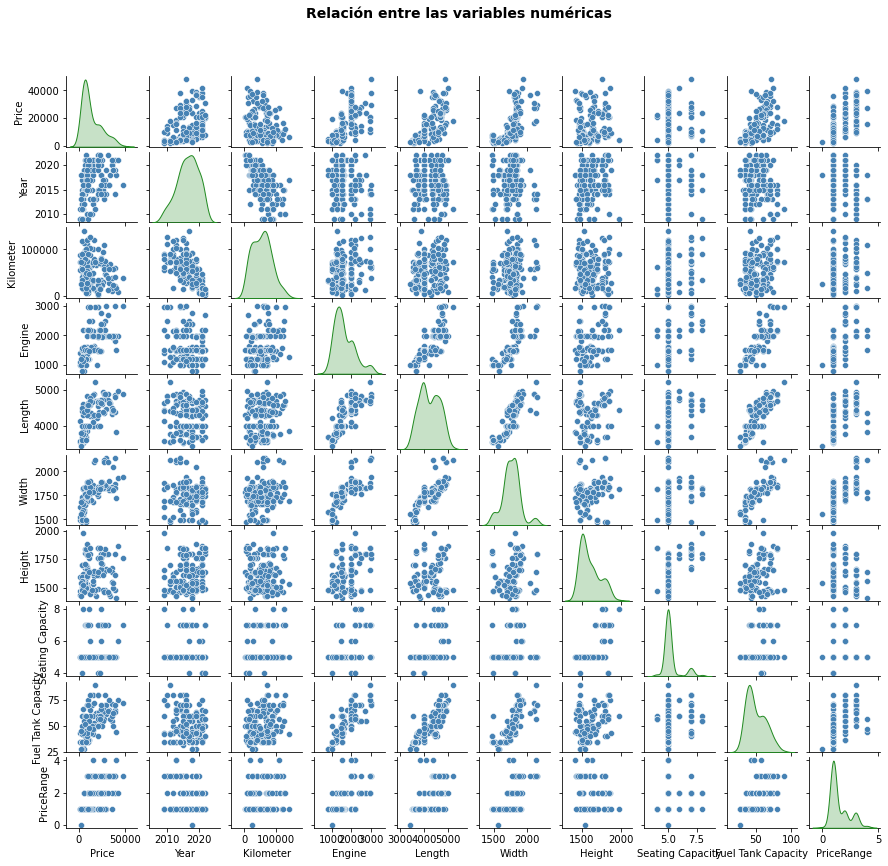

In [11]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, dp , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [12]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price')

### Variable de salida

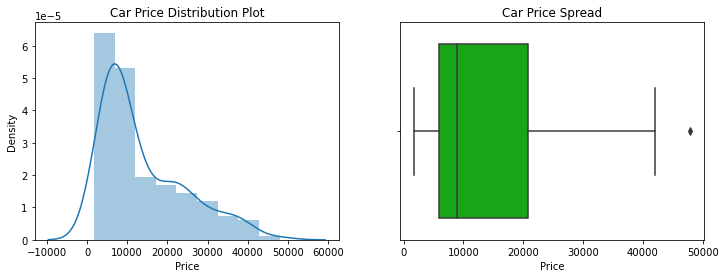

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(dp.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=dp.Price, palette='nipy_spectral')

plt.show()

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(dp.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count     161
mean    13701
std     10436
min      1692
25%      6000
50%      9000
75%     20748
85%     25788
90%     29400
95%     35880
97.5%   38400
100%    47940
max     47940
Name: Price, dtype: float64


## 5. Transformación de datos

### Creación de variables Dummies 

In [15]:
# Aplicación de la función de usuario Dummies: one-hot encoding

dp =pd.get_dummies(dp, drop_first=1)

dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   161 non-null    float64
 1   Year                    161 non-null    float64
 2   Kilometer               161 non-null    float64
 3   Engine                  161 non-null    float64
 4   Length                  161 non-null    float64
 5   Width                   161 non-null    float64
 6   Height                  161 non-null    float64
 7   Seating Capacity        161 non-null    float64
 8   Fuel Tank Capacity      161 non-null    float64
 9   PriceRange              161 non-null    int64  
 10  Fuel Type_Otro          161 non-null    uint8  
 11  Fuel Type_Petrol        161 non-null    uint8  
 12  Transmission_Manual     161 non-null    uint8  
 13  Owner_Second            161 non-null    uint8  
 14  Owner_Third             161 non-null    ui

### Columnas categóricas faltantes

In [16]:
#Carga del dataset

d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')
d.shape

(1441, 15)

In [17]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.shape

(1441, 21)

In [18]:
# Obtener las columnas categóricas que están en el dataframe original pero no en el dataset de pruebas

missingCols = set(d.columns) - set(dp.columns)
missingCols

{'Owner_Fourth', 'Seller Type_Corporate'}

In [19]:
# Agregar columnas con valores predeterminados 0
for col in missingCols:
    dp[col] = 0

In [20]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

Xp = dp.drop(columns ='Price')
yp = dp['Price']

In [21]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Cargar el scaler
scaler = joblib.load('./modelos/scaler/minmaxFull_carDetailsV4.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
Xp[numCols] = scaler.transform(Xp[numCols])

Xp[numCols].head(2)

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,0.9118,0.2557,0.1044,0.3231,0.3814,0.3052,0.5000,0.1370,0.4000
1,0.8824,0.4739,0.4134,0.7216,0.5014,0.7135,0.8333,0.3836,0.4000


## 6. Creación del modelo

#### Creación y entrenamiento del modelo

In [22]:
Xp.shape

(161, 20)

In [23]:
Xp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    161 non-null    float64
 1   Kilometer               161 non-null    float64
 2   Engine                  161 non-null    float64
 3   Length                  161 non-null    float64
 4   Width                   161 non-null    float64
 5   Height                  161 non-null    float64
 6   Seating Capacity        161 non-null    float64
 7   Fuel Tank Capacity      161 non-null    float64
 8   PriceRange              161 non-null    float64
 9   Fuel Type_Otro          161 non-null    uint8  
 10  Fuel Type_Petrol        161 non-null    uint8  
 11  Transmission_Manual     161 non-null    uint8  
 12  Owner_Second            161 non-null    uint8  
 13  Owner_Third             161 non-null    uint8  
 14  Owner_UnRegistered Car  161 non-null    ui

In [24]:
# Ruta donde se encuentran los modelos
ruta_modelos = './modelos/regresion'
ruta_resultados = './resultados/'


#dr=pd.read_csv('./resultados/resultadosModelosClasificacion.csv')
#dr

In [25]:
# Lista para almacenar los modelos cargados
modelos_cargados = []
dr = pd.DataFrame()

# Itera sobre los archivos en la ruta
for archivo_modelo in os.listdir(ruta_modelos):
    # Comprueba si el archivo es un modelo (puedes ajustar esta comprobación según tu estructura de nombres)
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, archivo_modelo)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)

        
        # Agrega el modelo a la lista
        modelos_cargados.append(archivo_modelo)

        # Realizar predicciones (opcional)
        y_pred = modelo_cargado.predict(Xp)

        #leer el archivo de resultados
        #dr = pd.read_csv('./resultados/resultadosModelosClasificacion.csv')

        # Adicionar una nueva fila 
        nuevoModelo = {'model': archivo_modelo
                      , 'Descripcion': modelo_cargado
                      , 'r2_score': metrics.r2_score(yp, y_pred)
                      , 'mae': metrics.mean_absolute_error(yp, y_pred)
                      , 'rmse': np.sqrt(metrics.mean_squared_error(yp, y_pred))                    
                     }
        dr = dr.append(nuevoModelo, ignore_index=True)

# Guardar el DataFrame actualizado de nuevo en el archivo CSV
#dr.to_csv('./resultados/resultadosModelosRegresion.csv', index=False)

# Imprimir el DataFrame actualizado
dr

,model,Descripcion,r2_score,mae,rmse
0,ABoostR_CV.pkl,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.8508,2929.9154,4018.7324
1,DTreeR_CV.pkl,"DecisionTreeRegressor(max_depth=10, max_featur...",-1.1428,11150.8351,15228.5650
2,GBoostR_CV.pkl,([DecisionTreeRegressor(criterion='friedman_ms...,0.9540,1494.7748,2230.1384
3,RForest_CV.pkl,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.9445,1519.9906,2451.5616
4,SVR_CV_poly.pkl,"SVR(C=1000, gamma=1, kernel='poly')",0.8282,3073.7278,4312.4536


In [26]:
 # Guardar el DataFrame actualizado de nuevo en el archivo CSV
#dr.to_csv('./resultados/resultadosModelosRegresion.csv', index=False)

In [28]:
# Top 3 de los mejores modelos
dr.sort_values(by='r2_score', ascending=False).head()

,model,Descripcion,r2_score,mae,rmse
2,GBoostR_CV.pkl,([DecisionTreeRegressor(criterion='friedman_ms...,0.9540,1494.7748,2230.1384
3,RForest_CV.pkl,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.9445,1519.9906,2451.5616
0,ABoostR_CV.pkl,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.8508,2929.9154,4018.7324
4,SVR_CV_poly.pkl,"SVR(C=1000, gamma=1, kernel='poly')",0.8282,3073.7278,4312.4536
1,DTreeR_CV.pkl,"DecisionTreeRegressor(max_depth=10, max_featur...",-1.1428,11150.8351,15228.5650


#### Referencias


- Maquinas de vectores de soporte

    - https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html
    
    ROC
    - https://stackabuse.com/understanding-roc-curves-with-python/



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html